In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt


In [47]:
combined_data = [file for file in glob.glob1("data/RNASeq_bw", "*stranded*") if "unstranded" not in file]
combined_tab_files = [file for file in combined_data if file.endswith(".tab")]
combined_tab_files_name_sorted = sorted(combined_tab_files, key=lambda x: x[0])
combined_tab_files_names = [file[ :file.find("_")] for file in combined_tab_files]

In [3]:
# Plotting the sum of the 3 bins around the TSS vs each gene.
GM12878_files = []
K562_files = []

GM12878_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/GM12878/Neighborhoods/GeneList.txt", sep="\t")
K562_gene_list = pd.read_csv("data/ABC-multiTSS_nominated/K562/Neighborhoods/GeneList.txt", sep="\t")
rna_cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")

with pd.option_context("mode.chained_assignment", None):
    for file in tqdm(combined_tab_files, desc="File"):
        file_name = file[ :file.find("_")]
        cell_line = file[ :file.find(".")]
        gene_list = None

        if cell_line == "K562":
            gene_list = K562_gene_list
        elif cell_line == "GM12878":
            gene_list = GM12878_gene_list

        df = pd.read_csv(f"data/RNASeq/{file}", sep="\t")

        # Summing from the TSS to the right of the sample.
        df_tss = df.iloc[:, 62:]
        df_tss.loc[:, "ENSID"] = gene_list.loc[:, "Ensembl_ID"]
        df_tss.loc[:, "Sum"] = df_tss.iloc[:, :-1].sum(axis=1)
        reorder = list(df_tss)[-2:-1] + list(df_tss)[:-2] + list(df_tss)[-1:]
        df_tss = df_tss.loc[:, reorder]

        if cell_line == "K562":
            K562_files.append(df_tss.loc[:, "Sum"])
        elif cell_line == "GM12878":
            GM12878_files.append(df_tss.loc[:, "Sum"])

        plt.plot(range(len(df_tss)), df_tss.loc[: ,"Sum"])
        plt.xlabel("Gene")
        plt.ylabel("Sum of Bins")
        plt.title("Genes vs Sum of the TSS and the Bins to the Right")
        plt.savefig(f"plots/dist_tss_sum/{file_name}.sum_tss_bins.png")
        plt.clf()

File: 0it [00:00, ?it/s]


In [21]:
# Plotting the correlation values of each file and its ground truth value in RNA_CAGE.txt

# Creating a dataframe that contains the 3-bin-sum for each file, the ENSID, and the ground truth value.
gm12878 = pd.DataFrame(GM12878_files).T
gm12878.insert(0, "a", GM12878_gene_list["Ensembl_ID"])
gm12878.columns = range(len(gm12878.columns))
gm12878 = gm12878.merge(rna_cage, left_on=0, right_on="ENSID", how="left")
gm12878 = gm12878.loc[:, (list(gm12878)[0:5] + list(gm12878)[7:8])]
gm12878["GM12878_CAGE_128*3_sum"] = gm12878["GM12878_CAGE_128*3_sum"].astype(float).fillna(0)
gm12878.to_csv("csvs/correlation/gm12878_rnaseq_rnacage.csv", index=False)

for col in gm12878.columns[1:5]:
    file_name = combined_tab_files_name_sorted[int(col) - 1][ :combined_tab_files_name_sorted[int(col) - 1].find("_")]
    plt.scatter(gm12878[col], gm12878["GM12878_CAGE_128*3_sum"])

    plt.xscale("log")
    plt.yscale("log")

    plt.ylabel("Actual Value (Log)")
    plt.xlabel("Ground Truth (Log)")
    plt.title(f"Scatter Plot for Correlation of {file_name} vs RNA_CAGE", fontsize=8)
    plt.savefig(f"plots/rnaseq_vs_rnacage/{file_name}.correlation_rna_cage_log.png")
    plt.clf()

k562 = pd.DataFrame(K562_files).T
k562.insert(0, "a", K562_gene_list["Ensembl_ID"])
k562.columns = range(len(k562.columns))
k562 = k562.merge(rna_cage, left_on=0, right_on="ENSID", how="left")
k562 = k562.loc[:, (list(k562)[0:5] + list(k562)[6:7])]
k562["K562_CAGE_128*3_sum"] = k562["K562_CAGE_128*3_sum"].astype(float).fillna(0)
k562.to_csv("csvs/correlation/k562_rnaseq_rnacage.csv", index=False)

for col in k562.columns[1:5]:
    file_name = combined_tab_files_name_sorted[int(col) - 1 + 4][ :combined_tab_files_name_sorted[int(col) - 1 + 4].find("_")]
    plt.scatter(k562[col], k562["K562_CAGE_128*3_sum"])

    plt.yscale("log")
    plt.xscale("log")

    plt.ylabel("Actual Value (Log)")
    plt.xlabel("Ground Truth (Log)")
    plt.title(f"Scatter Plot for Correlation of {file_name} vs RNA_CAGE", fontsize=8)
    plt.savefig(f"plots/rnaseq_vs_rnacage/{file_name}.correlation_rna_cage_log.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Generating the dataframes for the correlation and p-value values (RNA Seq vs RNA Cage).
GM12878_corr_df = pd.DataFrame()
for col in gm12878.columns[1:5]:
    pearson_r_values = stats.pearsonr(np.log(gm12878[col] + 1), np.log(gm12878["GM12878_CAGE_128*3_sum"] + 1))
    GM12878_corr_df = pd.concat([GM12878_corr_df, pd.DataFrame(pearson_r_values).T])
GM12878_corr_df = GM12878_corr_df.rename(columns={0: "PearsonR", 1: "PValue"})
GM12878_corr_df["Sample"] = [file for file in combined_tab_files_names if file[0] == "G"]
GM12878_corr_df.to_csv("csvs/correlation/rnaseq_vs_rnacage/GM12878.correlation_pvalue_log.csv")

# Pearson R: 0.14500713488288372
# PValue: 1.2354172154320445e-17

# Pearson R (Log): 0.13537539028281445
# PValue (Log): 4.208102991973101e-79
print(f"GM12878 Average PearsonR: {GM12878_corr_df.iloc[:, 0:2].mean().iloc[0]}\nAverage PValue: {GM12878_corr_df.iloc[:, 0:2].mean().iloc[1]}")

K562_corr_df = pd.DataFrame()
for col in k562.columns[1:5]:
    pearson_r_values = stats.pearsonr(np.log(k562[col] + 1), np.log(k562["K562_CAGE_128*3_sum"] + 1))
    K562_corr_df = pd.concat([K562_corr_df, pd.DataFrame(pearson_r_values).T])
K562_corr_df = K562_corr_df.rename(columns={0: "PearsonR", 1: "PValue"})
K562_corr_df["Sample"] = [file for file in combined_tab_files_names if file[0] == "K"]

K562_corr_df.to_csv("csvs/correlation/rnaseq_vs_rnacage/K562.correlation_pvalue_log.csv")

# Pearson R: 0.24022424698280365
# PValue: 8.614336307937462e-100

# Pearson R (Log): 0.14187766207637342
# PValue (Log): 3.3351711137892027e-110 
print(f"K562 Average PearsonR: {K562_corr_df.iloc[:, 0:2].mean().iloc[0]}\nAverage PValue: {K562_corr_df.iloc[:, 0:2].mean().iloc[1]}")

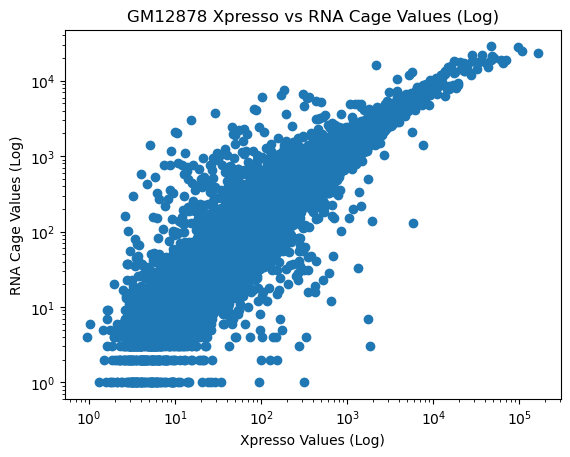

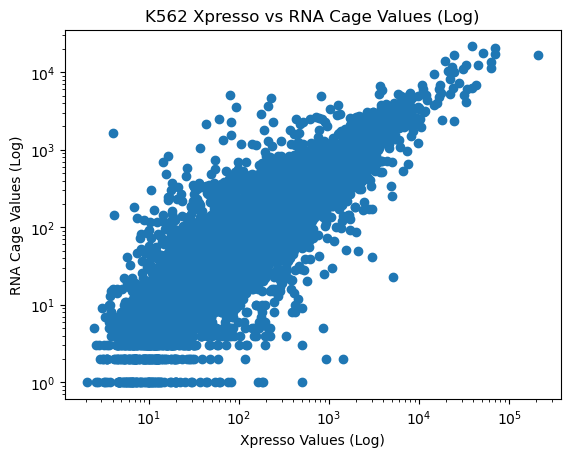

,PearsonR,PValue,Cell_Line
0,0.934270,0.0,GM12878
0,0.891924,0.0,K562


<Figure size 640x480 with 0 Axes>

In [ ]:
links = pd.read_csv("data/GM12878_enhancer_gene_links_100kb.hg38.tsv", sep="\t")
rna_cage_links = rna_cage.merge(links, left_on="ENSID", right_on="TargetGeneEnsembl_ID", how="inner", suffixes=["_rna_cage", "_links"])
xpresso = pd.read_csv("data/GM12878_K562_18377_gene_expr_fromXpresso.csv")
xpresso["chrom"] = "chr" + xpresso["chrom"]

rna_cage_links_xpresso = rna_cage_links.merge(xpresso, left_on="ENSID_old", right_on="gene_id", how="inner", suffixes=["_rna_cage", "_xpresso"])

rna_cage_links_xpresso["diffTSS-dist"] = abs(rna_cage_links_xpresso["TargetGeneTSS"] - rna_cage_links_xpresso["TSS_xpresso"])
min_dist_indx = rna_cage_links_xpresso.groupby("ENSID_old")["diffTSS-dist"].idxmin()

epi_xpresso = rna_cage_links_xpresso.loc[min_dist_indx]
epi_xpresso = epi_xpresso.loc[:, (list(epi_xpresso)[0:3] + list(epi_xpresso)[-8:-7] + list(epi_xpresso)[-6:-5])]
gm_only = epi_xpresso.iloc[:, ::2].dropna()
k5_only = epi_xpresso.loc[:, (list(epi_xpresso)[0: 2] + list(epi_xpresso)[3:4])].dropna()

plt.scatter(gm_only["GM12878_CAGE_128*3_sum_rna_cage"], gm_only["GM12878_CAGE_128*3_sum_xpresso"])
plt.xlabel("Xpresso Values (Log)")

plt.yscale("log")
plt.xscale("log")

plt.ylabel("RNA Cage Values (Log)")
plt.title("GM12878 Xpresso vs RNA Cage Values (Log)")
plt.savefig("plots/rnacage_vs_xpresso/GM12878.rna_cage_xpresso_inner_log.png")
plt.clf()

cage_xpresso = pd.DataFrame()
corr = stats.pearsonr(np.log(gm_only["GM12878_CAGE_128*3_sum_xpresso"] + 1), np.log(gm_only["GM12878_CAGE_128*3_sum_rna_cage"] + 1))
cage_xpresso = pd.concat([cage_xpresso, pd.DataFrame(corr).T])

plt.scatter(k5_only["K562_CAGE_128*3_sum_rna_cage"], k5_only["K562_CAGE_128*3_sum_xpresso"])
plt.xlabel("Xpresso Values (Log)")

plt.xscale("log")
plt.yscale("log")

plt.ylabel("RNA Cage Values (Log)")
plt.title("K562 Xpresso vs RNA Cage Values (Log)")
plt.savefig("plots/rnacage_vs_xpresso/K562.rna_cage_xpresso_inner_log.png")
plt.clf()

corr = stats.pearsonr(np.log(k5_only["K562_CAGE_128*3_sum_rna_cage"] + 1), np.log(k5_only["K562_CAGE_128*3_sum_xpresso"] + 1))
cage_xpresso = pd.concat([cage_xpresso, pd.DataFrame(corr).T])
cage_xpresso["Cell_Line"] = ["GM12878", "K562"]
cage_xpresso = cage_xpresso.rename({0: "PearsonR", 1:"PValue"}, axis=1)
# cage_xpresso.to_csv("csvs/correlation/rnacage_vs_xpresso/cage_xpresso.correlation_inner_log.csv", index=False)

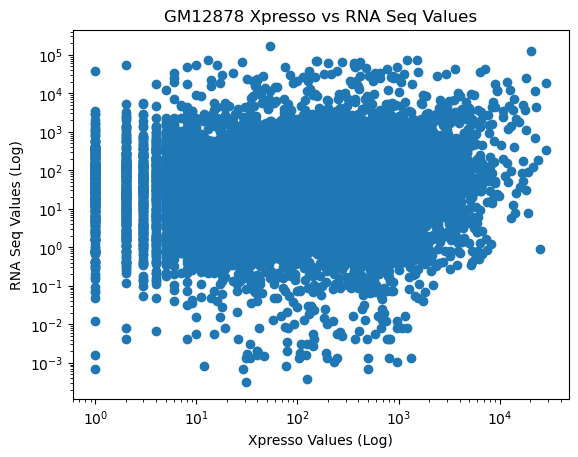

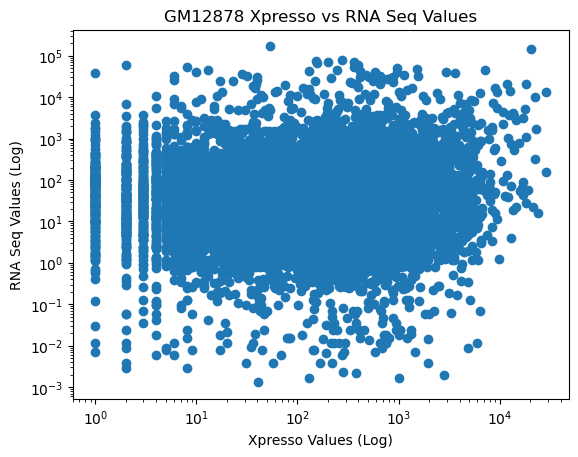

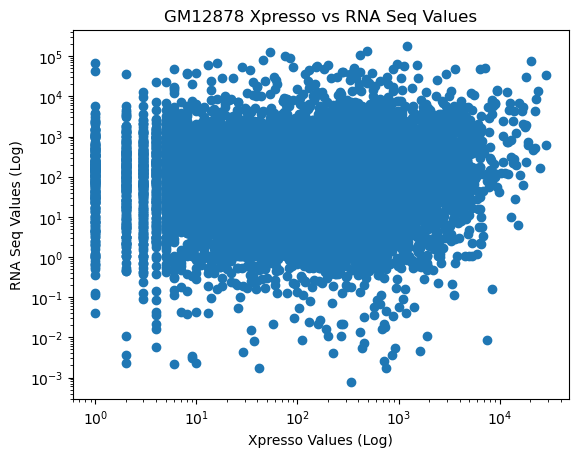

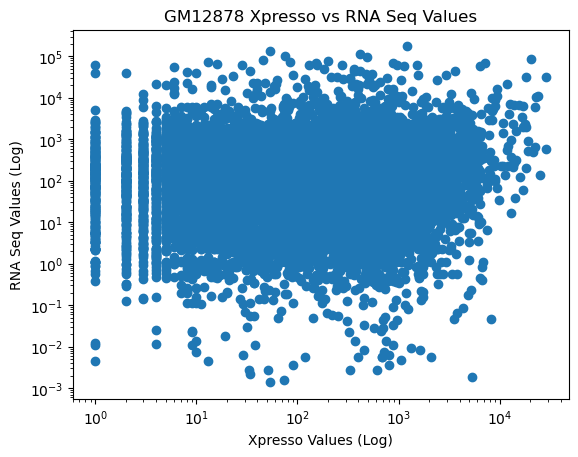

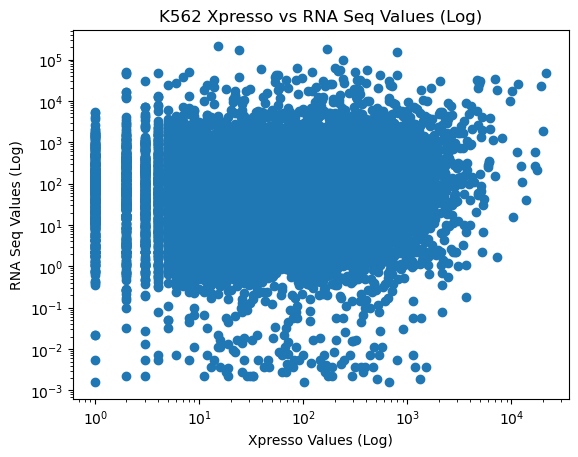

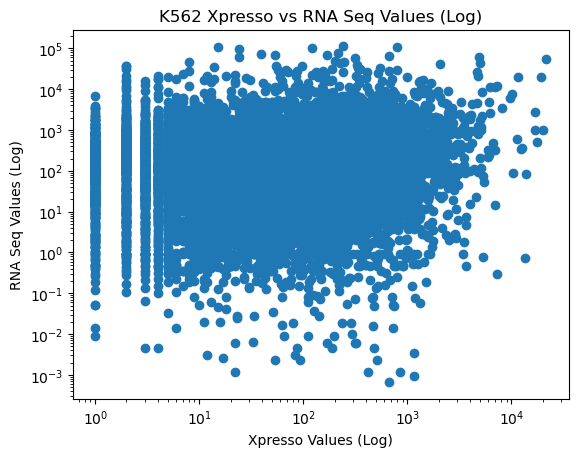

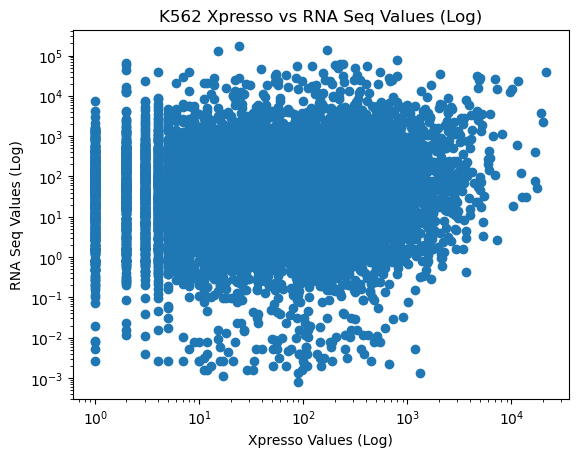

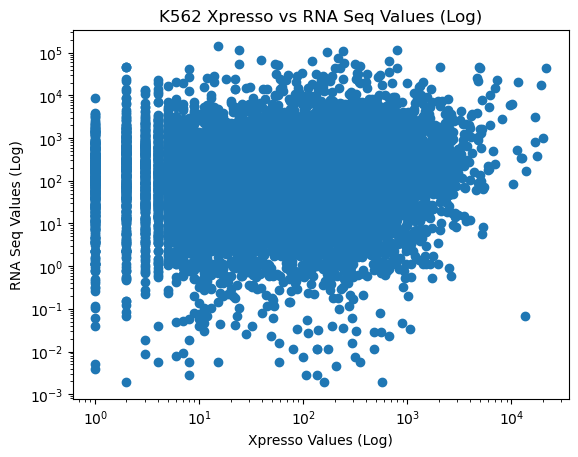

<Figure size 640x480 with 0 Axes>

In [50]:
# Plotting RNA Seq vs Xpresso
gm12878 = pd.read_csv("csvs/correlation/gm12878_rnaseq_rnacage.csv")
k562 = pd.read_csv("csvs/correlation/k562_rnaseq_rnacage.csv")
xpresso = pd.read_csv("data/GM12878_K562_18377_gene_expr_fromXpresso.csv")

gm_xpresso = gm12878.merge(xpresso, left_on="0", right_on="gene_id", how="inner")
gm_xpresso = gm_xpresso.loc[:, (list(gm_xpresso)[0:14] + list(gm_xpresso)[-5:-4])]
gm_xpresso["GM12878_CAGE_128*3_sum_y"] = gm_xpresso["GM12878_CAGE_128*3_sum_y"].astype(float).fillna(0)

k5_xpresso = k562.merge(xpresso, left_on="0", right_on="gene_id", how="inner")
k5_xpresso = k5_xpresso.loc[:, (list(k5_xpresso)[0:14] + list(k5_xpresso)[-7:-6])]
k5_xpresso["K562_CAGE_128*3_sum_y"] = k5_xpresso["K562_CAGE_128*3_sum_y"].astype(float).fillna(0)

gm_xpresso_correlation = pd.DataFrame()
k5_xpresso_correlation = pd.DataFrame()

for col in gm_xpresso.columns[1:5]:
    file_name = combined_tab_files_name_sorted[int(col) - 1][ :combined_tab_files_name_sorted[int(col) - 1].find("_")]

    pearson_r_values = stats.pearsonr(np.log(gm_xpresso["GM12878_CAGE_128*3_sum_y"] + 1), np.log(gm_xpresso[col] + 1))
    gm_xpresso_correlation = pd.concat([gm_xpresso_correlation, pd.DataFrame(pearson_r_values).T])

    plt.scatter(gm_xpresso["GM12878_CAGE_128*3_sum_y"], gm_xpresso[col])
    plt.xlabel("Xpresso Values (Log)")

    plt.xscale("log")
    plt.yscale("log")

    plt.ylabel("RNA Seq Values (Log)")
    plt.title("GM12878 Xpresso vs RNA Seq Values")
    plt.show()
    # plt.savefig(f"plots/rnaseq_vs_xpresso/{file_name}.rna_seq_xpresso_inner_log.png")
    plt.clf()

gm_xpresso_correlation = gm_xpresso_correlation.rename(columns={0: "PearsonR", 1: "PValue"})
gm_xpresso_correlation["Sample"] = [file for file in combined_tab_files_names if file[0] == "G"]
gm_xpresso_correlation.to_csv("csvs/correlation/rnaseq_vs_xpresso/GM12878_Xpresso.correlation_pvalue_inner_log.csv", index=False)

for col in k5_xpresso.columns[1:5]:
    file_name = combined_tab_files_name_sorted[int(col) - 1 + 4][ :combined_tab_files_name_sorted[int(col) - 1 + 4].find("_")]

    pearson_r_values = stats.pearsonr(np.log(k5_xpresso["K562_CAGE_128*3_sum_y"] + 1), np.log(k5_xpresso[col] + 1))
    k5_xpresso_correlation = pd.concat([k5_xpresso_correlation, pd.DataFrame(pearson_r_values).T])

    plt.scatter(k5_xpresso["K562_CAGE_128*3_sum_y"], k5_xpresso[col])
    plt.xlabel("Xpresso Values (Log)")

    plt.xscale("log")
    plt.yscale("log")

    plt.ylabel("RNA Seq Values (Log)")
    plt.title("K562 Xpresso vs RNA Seq Values (Log)")
    plt.show()
    # plt.savefig(f"plots/rnaseq_vs_xpresso/{file_name}.rna_seq_xpresso_inner_log.png")
    plt.clf()

k5_xpresso_correlation = k5_xpresso_correlation.rename(columns={0: "PearsonR", 1: "PValue"})
k5_xpresso_correlation["Sample"] = [file for file in combined_tab_files_names if file[0] == "K"]
k5_xpresso_correlation.to_csv("csvs/correlation/rnaseq_vs_xpresso/K562_Xpresso.correlation_pvalue_inner_log.csv",index=False)